In [1]:
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import xarray as xr
import pandas as pd
from scipy import special, stats
import numpy as np
import seaborn as sns

np.random.seed(42)

In [2]:
penguins = pd.read_csv("data/penguins.csv")
# удалим пропущенные данные
penguins = penguins.dropna(axis=0)

adelie_mask = penguins["species"] == "Adelie"
adelie_mass_obs = penguins.loc[adelie_mask, "body_mass_g"].values

penguins.tail()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009
343,Chinstrap,Dream,50.2,18.7,198.0,3775.0,female,2009


В предыдущем разделе мы смоделировали распределение веса пингвинов, установив предыдущие распределения по среднему и стандартному отклонению нормального распределения. 

Важно отметить, что мы предположили, что вес не отличается от других особенностей в данных. Однако мы ожидаем, что другие наблюдаемые данные могут предоставить информацию об ожидаемом весе пингвинов. 

Интуитивно, если мы увидим двух пингвинов, одного с длинными плавниками и одного с короткими плавниками, мы ожидаем, что пингвин с длинными плавниками, будет иметь большую массу, даже если бы у нас не было под рукой весов для точного измерения их массы. 

Одним из самых простых способов оценки этой взаимосвязи наблюдаемой длины плавника на оценку веса пингвина является о модели линейной регрессии, где среднее значение условно моделируется как линейная комбинация других переменных

$$
\begin{split}
\mu =& \beta_0 + \beta_1 X_1 + \dots + \beta_m X_m = \beta X \\
Y \sim& \mathcal{N}(\mu, \sigma)
\end{split}$$

где коэффициенты $\beta_i$. Например, $\beta_0$ это величина сдвига линейной модели.
$X_i$ являются независимым переменными, и $Y$ обычно называется целевой или зависимой переменной. Важно отметить, что обе переменными наблюдаюся в паре $\{X_i, y_i\}$ и изменение одной из них приводит к изменению другой.

Важно понимать, что модель называется линейной регрессией, потому что коэффициенты входят в модель линейно. Поэтому для моделей с одной переменной, мы можем представить модель как задачу подгонке линии к
данных, а для более высоких измерений подгонку плоскости или, в более общем плане, гиперплоскости.

Для эконетрических моделелей (не байесовских моделей) модель описывается как линейное предсказание с шумом:
$$
Y = \beta X + \varepsilon,\;\; \varepsilon \sim \mathcal{N}(0, \sigma)
$$
Формулировка в уравнении разделяет детерминированную часть (линейное предсказание) и стохастическую часть (шум) линейной регрессии. 

Однако, мы будем использовать ранее указанную запись, так как оно более четко показывает генеративный характер модели.

Если мы нарисуем уравнение 
$$
\begin{split}
\mu =& \beta_0 + \beta_1 X_1 + \dots + \beta_m X_m = \beta X \\
Y \sim& \mathcal{N}(\mu, \sigma)
\end{split}$$
в «трех измерениях», то получим рисуноек, который показывает, как оценонные параметры распределения правдоподобия могут измениться на основе  наблюдаемых данных $x$. 

<img src="img/3d_linear_regression.png" width="400" height="400" class="center">

В модели мы используем линейную взаимосвязи между переменными, далее поговорим и о других взаимосвязях.


Попробуем уточнить нашу модель про пингвинов, мы хотим, используя дополнительных данных,  улучшить оцунку среднего веса группы пингвинов. Используя линейную регрессию, мы запишим модель, которая включает в себя два новых параметра $\beta_0$ и $\beta_1$, которые характеризуют сдвиг и наклон. 

Для этого примера мы устанавливаем широкие априорные распределения, что позволит сосредоточиться на модели, предполога, что у нас нет никакой предварительной информации.

In [6]:
adelie_flipper_length_obs = penguins.loc[adelie_mask, "flipper_length_mm"]

with pm.Model() as model_adelie_flipper_regression:
    # pm.Data используется если в переменную будем добовлять предсказания, иначе не нужно
    adelie_flipper_length = pm.Data("adelie_flipper_length",
                                     adelie_flipper_length_obs)
    σ = pm.HalfStudentT("σ", 100, 2000)
    β_0 = pm.Normal("β_0", 0, 4000)
    β_1 = pm.Normal("β_1", 0, 4000)
    μ = pm.Deterministic("μ", β_0 + β_1 * adelie_flipper_length)

    mass = pm.Normal("mass", mu=μ, sigma=σ, observed=adelie_mass_obs)

    idata_adelie_flipper_regression = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β_0, β_1]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


После завершения работы нашего сэмплера мы можем построить табличку и график, который показывает апостериорные прлотности вероятностей, используемые для нахождения $\beta_0$ и $\beta_1$.

In [8]:
az.summary(idata_adelie_flipper_regression, 
           var_names=["β_0","β_1", "σ"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β_0,-2413.694,868.718,-3974.787,-749.826,23.482,16.780,1365.0,1394.0,1.0
β_1,32.195,4.567,23.326,40.331,0.123,0.087,1365.0,1446.0,1.0
σ,365.811,17.856,334.598,399.957,0.438,0.311,1689.0,1580.0,1.0


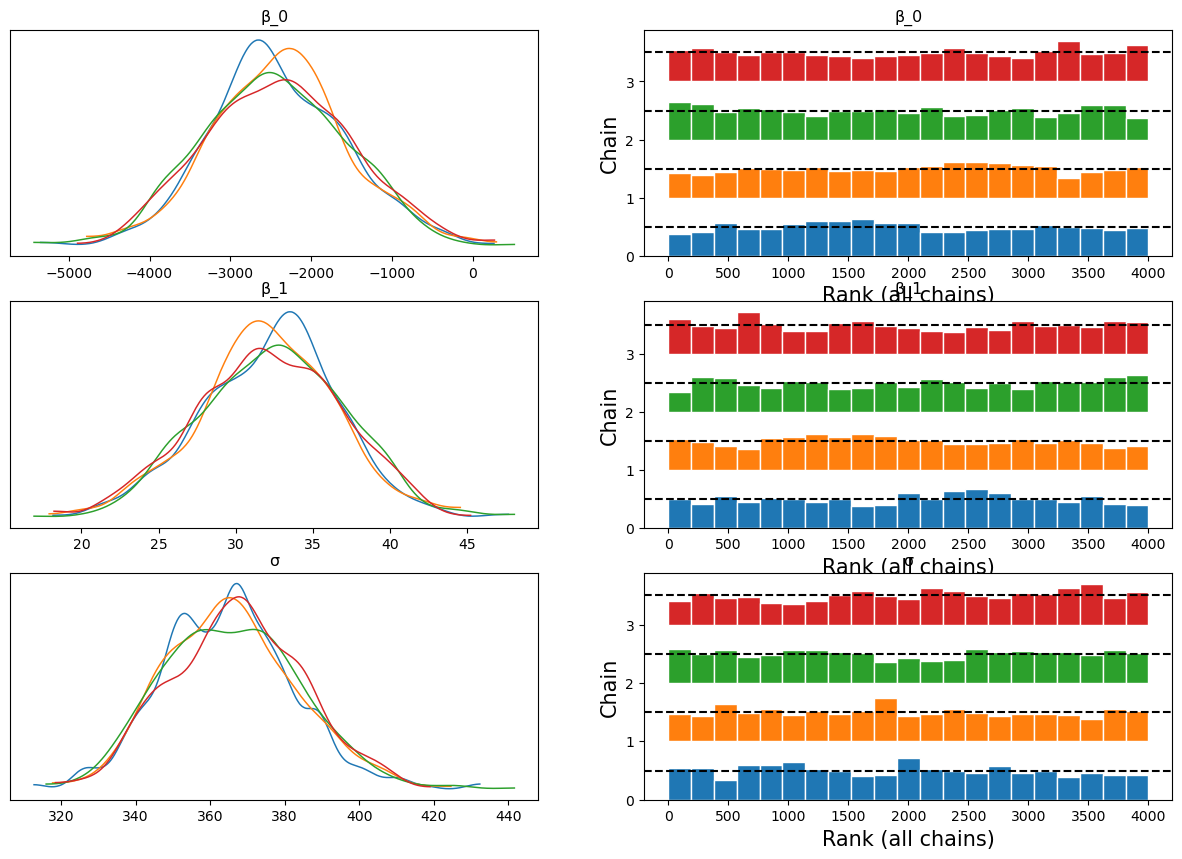

In [9]:
axes = az.plot_trace(idata_adelie_flipper_regression, compact=False,
                     var_names=["β_0","β_1", "σ"],
                     divergences="bottom", kind="rank_bars", figsize=(15, 10),
                     );

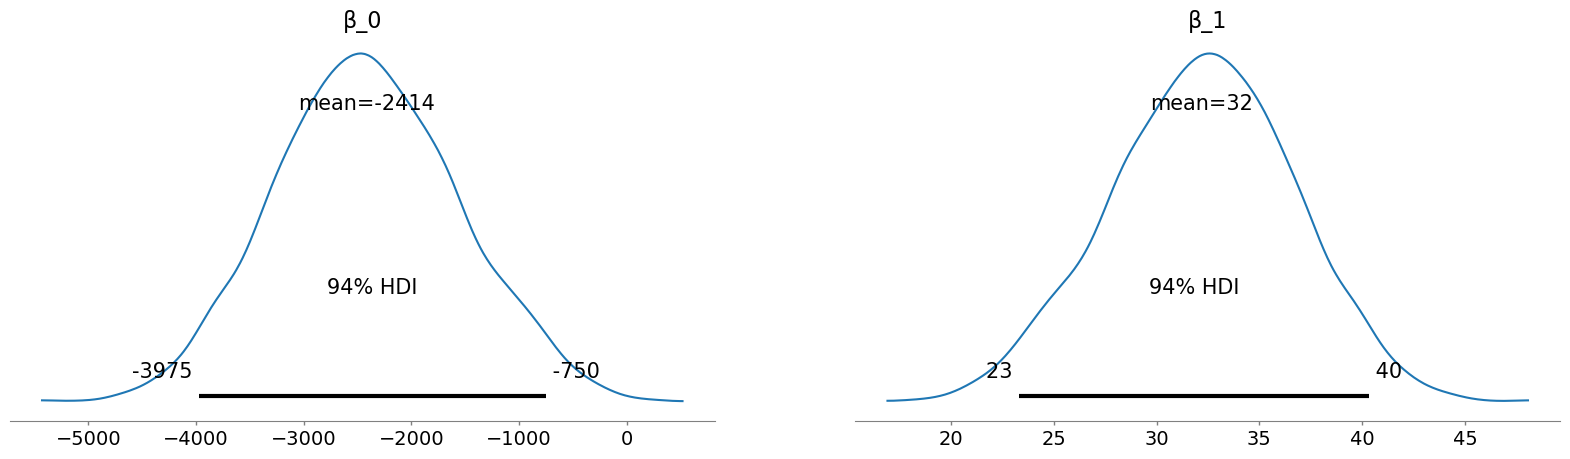

In [10]:
axes = az.plot_posterior(idata_adelie_flipper_regression, var_names = ["β_0", "β_1"], figsize=(20, 5));


Коэффициент $\beta_1$ показывает, что при каждом изменении длины плавника пингвина Adelie на 1 мм мы можем  ожидать изменения массы на 32 грамма, хотя вполне возможно, что это произойдет и в диапазоне от 22 до 41 грамма. 

Кроме того, мы можем заметить, что интервал наибольшей плотности в 94% не пересекает линию веса в 0 граммов. Это подтверждает наше предположение о том, что существует взаимосвязь между массой и длиной плавника. Это наблюдение весьма полезно для интерпретации того, как соотносятся длина и масса плавника. Однако мы должны быть осторожны, чтобы не переоценивать коэффициенты и не думать, что линейная модель обязательно подразумевает причинно-следственную связь.  
Например, если мы проведем операцию по удлинению плавников у пингвина, это не обязательно приведет к увеличению массы, на самом деле может быть наоборот, из-за стресса или сложностей, с которыми этот пингвин сталкивается при получении пищи.   
Обратное соотношение также не обязательно верно: если давать пингвину больше пищи, у него могут вырасти плавники, но это также может сделать его просто толще. 

Теперь сосредоточимся $\beta_0$ на однако, что это означает? Исходя из наших предварительных оценок, мы можем утверждать, что если бы мы увидели пингвина Adelie с длиной плавников 0 мм, мы бы ожидали, что масса этого невозможного пингвина будет где-то между -4151 и -510 граммами.   
Согласно нашей модели, это утверждение верно, но отрицательная масса не имеет смысла. Это не обязательно является проблемой, нет правила, согласно которому каждый параметр в модели должен быть интерпретируемым, или что модель обеспечивает разумный прогноз при каждом значении параметра. На данном этапе для этой конкретной модели было необходимо оценить взаимосвязь между длиной плавников и массой пингвина, и, благодаря нашим предварительным оценкам, мы преуспели в достижении этой цели :)

In [12]:
import pickle
with open('idata_adelie_mass.pkl', 'rb') as f:
    idata_adelie_mass = pickle.load(f)

Мы начали этот моделирование, предпологая, что включение новой объясняющей переменной приведет к лучшим прогнозам массы пингвинов. Мы можем убедиться, что это так, сравнив апостериорные оценки.

Из нашей фиксированной модели средних весов и с нашей линейной моделью средних весов, наша оценка стандартного отклонения вероятности снизилась со среднего значения примерно с 410 до 366 грамм

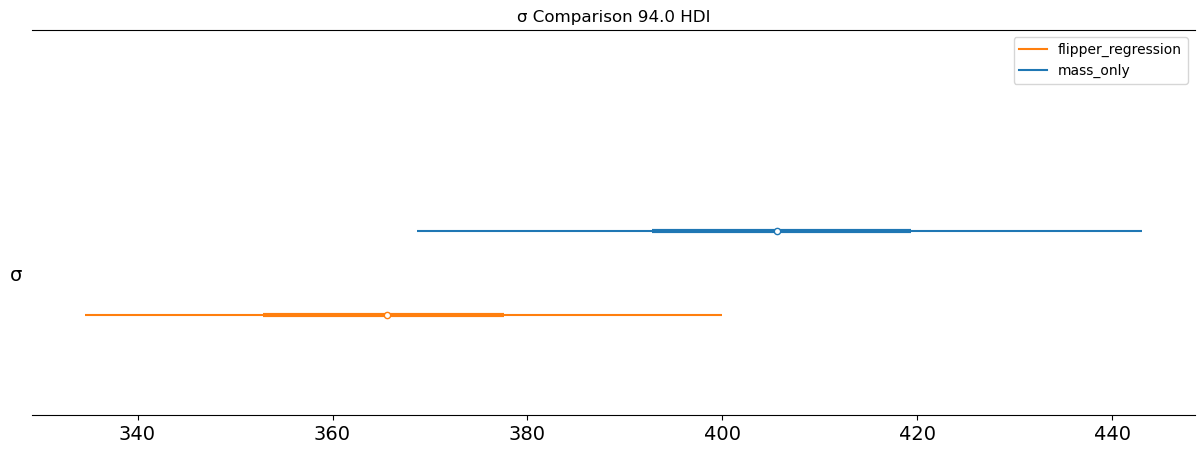

In [14]:
axes = az.plot_forest(
    [idata_adelie_mass, idata_adelie_flipper_regression],
    model_names=["mass_only", "flipper_regression"],
    var_names=["σ"], combined=True, figsize=(15, 5))
axes[0].set_title("σ Comparison 94.0 HDI");

In [15]:
from sklearn.linear_model import LinearRegression
X = adelie_flipper_length_obs.values.reshape(-1,1)
y = adelie_mass_obs

model = LinearRegression().fit(X, y)
y_pred = model.predict(X) 
# plt.scatter(X, y, color ='b') 
# plt.plot(X, y_pred, color ='k');

А результаты моделирования видны ниже:

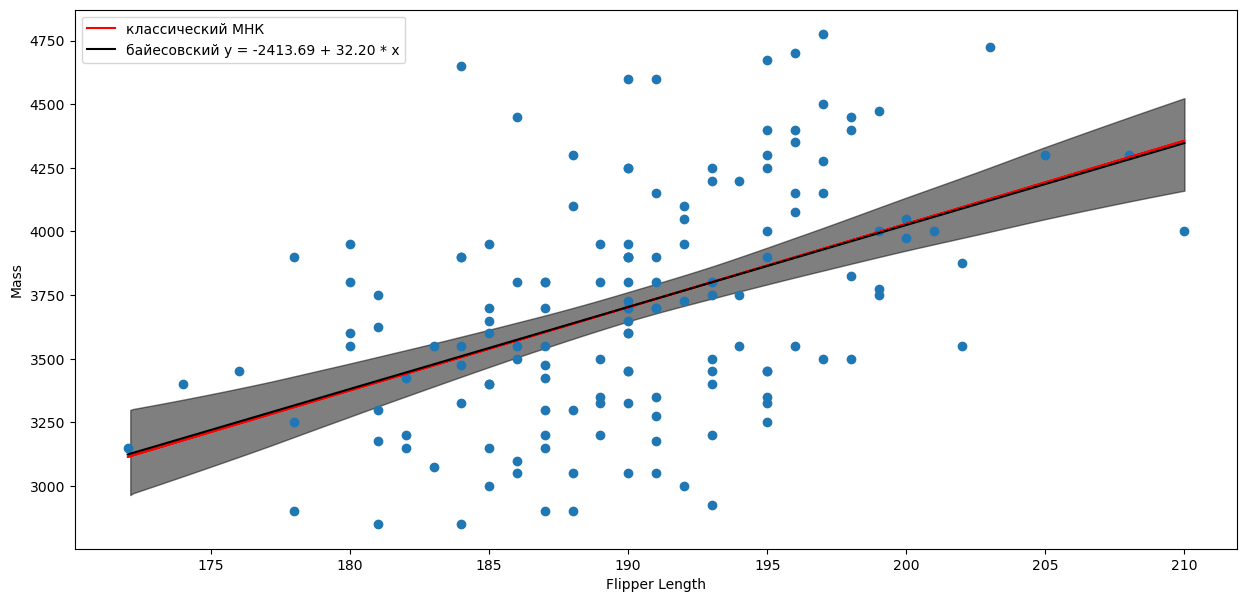

In [17]:
fig, ax = plt.subplots(figsize=(15,7))
alpha_m = idata_adelie_flipper_regression.posterior["β_0"].mean().item()
beta_m = idata_adelie_flipper_regression.posterior["β_1"].mean().item()

flipper_length = np.linspace(adelie_flipper_length_obs.min(), adelie_flipper_length_obs.max(), 100)
flipper_length_mean = alpha_m + beta_m * flipper_length

az.plot_hdi(adelie_flipper_length_obs, idata_adelie_flipper_regression.posterior['μ'], hdi_prob=0.94, 
            color='k', ax=ax)
ax.plot(X, y_pred, color ='r', label='классический МНК') 
ax.plot(flipper_length, flipper_length_mean, c='k',
         label=f'байесовский y = {alpha_m:.2f} + {beta_m:.2f} * x')

ax.scatter(adelie_flipper_length_obs, adelie_mass_obs)


# Figure out how to do this from inference data
ax.legend(loc=2)
ax.set_xlabel('Flipper Length')
ax.set_ylabel('Mass');

В линейной модели плавники-вес мы оценили линейную зависимость между длиной плавника и весом. 

Еще одно применение регрессии - использовать эту зависимость для составления прогнозов. 

В нашем случае, учитывая длину плавника пингвина, можем ли мы предсказать его массу? На самом деле, мы можем. Для этого мы будем использовать наши результаты из `model_adelie_flipper_regression`. 

Поскольку в байесовской статистике мы имеем дело с распределениями, мы получаем не одно прогнозируемое значение, а распределение возможных значений. Это апостериорная плотнось распределение вероятностей.  
На практике, мы не будем вычислять наши прогнозы аналитически, а будем использовать компьютер для их оценки с использованием наших апостериорных выборок. 

Например, если бы у нас был пингвин со средней длиной плавников и мы хотели предсказать его вероятную массу с помощью PyMC, мы бы написали следующий кода `penguins_ppd`:

In [19]:
with model_adelie_flipper_regression:
    pm.set_data({"adelie_flipper_length": [adelie_flipper_length_obs.mean()]})
    posterior_predictions = pm.sample_posterior_predictive(
        idata_adelie_flipper_regression.posterior, var_names=["mass", "μ"])

Sampling: [mass]


Output()

Text(0.5, 0, 'Mass (grams)')

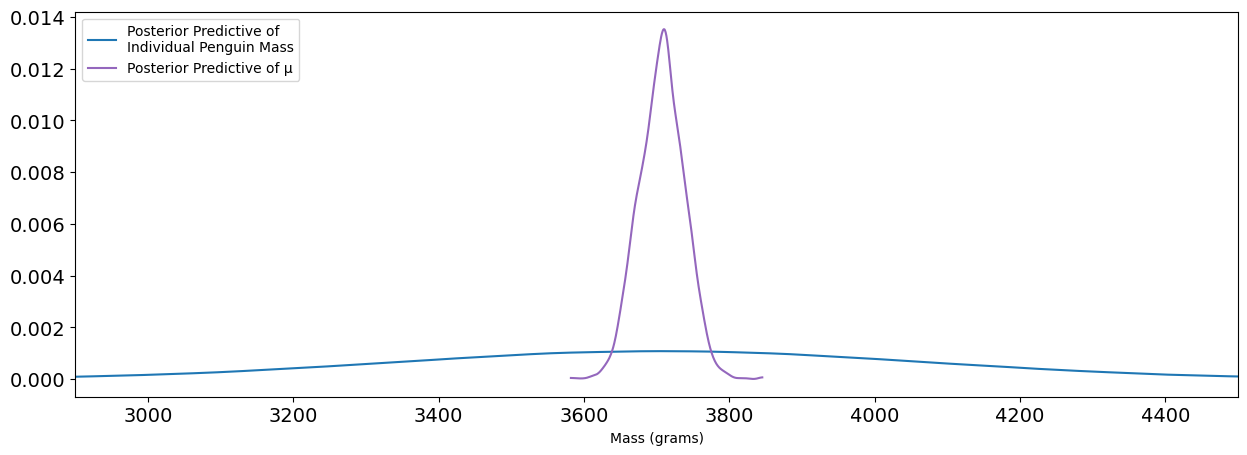

In [20]:
fig, ax = plt.subplots(figsize=(15,5))
az.plot_dist(posterior_predictions.posterior_predictive["mass"],
             label="Posterior Predictive of \nIndividual Penguin Mass", ax=ax)
az.plot_dist(posterior_predictions.posterior_predictive["μ"], label="Posterior Predictive of μ", color="C4", ax=ax)
ax.set_xlim(2900, 4500);
ax.legend(loc=2)
ax.set_xlabel("Mass (grams)")

В первой строке блока кода `penguins_ppd` мы привязываем значение длины ласт пингвина к средней наблюдаемой длине ласт. Затем, используя регрессионную модель `model_adelie_flipper_regression`, мы можем сгенерировать апостериорные прогностические выборки массы при этом фиксированном значении. 

Теперь мы строим апостериорное распределение веса для пингвинов с различной длиной плавников и апостерионого распределения среднего значения веса пингвина.

Иначе говоря, мы можем не только использовать нашу модель в `non_centered_regression` для оценки зависимости между длиной плавника и массой,но для получения ораспределения веса пингвина при любой произвольной длине плавника. Другими словами, мы можем использовать оцененные коэффициенты $\beta_0$ и $\beta_1$ для прогнозирования массы неизвестных нам пингвинов с любой длины плавников, используя апостериорные предсказательные распределения.

Таким образом, апостериорное прогнозирующее распределение является особенно мощным инструментом в байесовском контексте, поскольку оно позволяет нам прогнозировать не только наиболее вероятное значение, но и распределение вероятных значений, учитывающее неопределенность наших оценок.

Наша модель `non_centered_regression` хорошо зарекомендовала себя для оценки зависимости между длиной плавника и весом пингвина, а также для прогнозирования веса пингвинов при заданной длине плавника. 

К сожалению, с учетом данных и предоставленной модели наша оценка **веса** оказалась не особенно полезной. Однако мы можем использовать преобразование, чтобы сделать результат более понятным. 

В этом случае мы выберем центрирующее преобразование, которое принимает набор значений и центрирует его среднее значение на нуле, как показано в блоке кода `model_adelie_flipper_regression_c`.

In [23]:
adelie_flipper_length_c = (adelie_flipper_length_obs -
                           adelie_flipper_length_obs.mean())

with pm.Model() as model_adelie_flipper_regression_c:
    
    σ = pm.HalfStudentT("σ", 100, 2000)
    β_0 = pm.Normal("β_0", 0, 4000)
    β_1 = pm.Normal("β_1", 0, 4000)
    μ = pm.Deterministic("μ", β_0 + β_1 * adelie_flipper_length_c)

    mass = pm.Normal("mass", mu=μ, sigma=σ, observed=adelie_mass_obs)

    idata_adelie_flipper_regression_c = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β_0, β_1]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [24]:
az.summary(idata_adelie_flipper_regression_c, var_names = ["β_0", "β_1","σ"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β_0,3706.020,30.335,3650.676,3762.781,0.365,0.259,6880.0,3049.0,1.0
β_1,32.778,4.557,24.472,41.397,0.058,0.042,6176.0,3288.0,1.0
σ,365.336,18.200,332.171,401.246,0.230,0.163,6240.0,3074.0,1.0


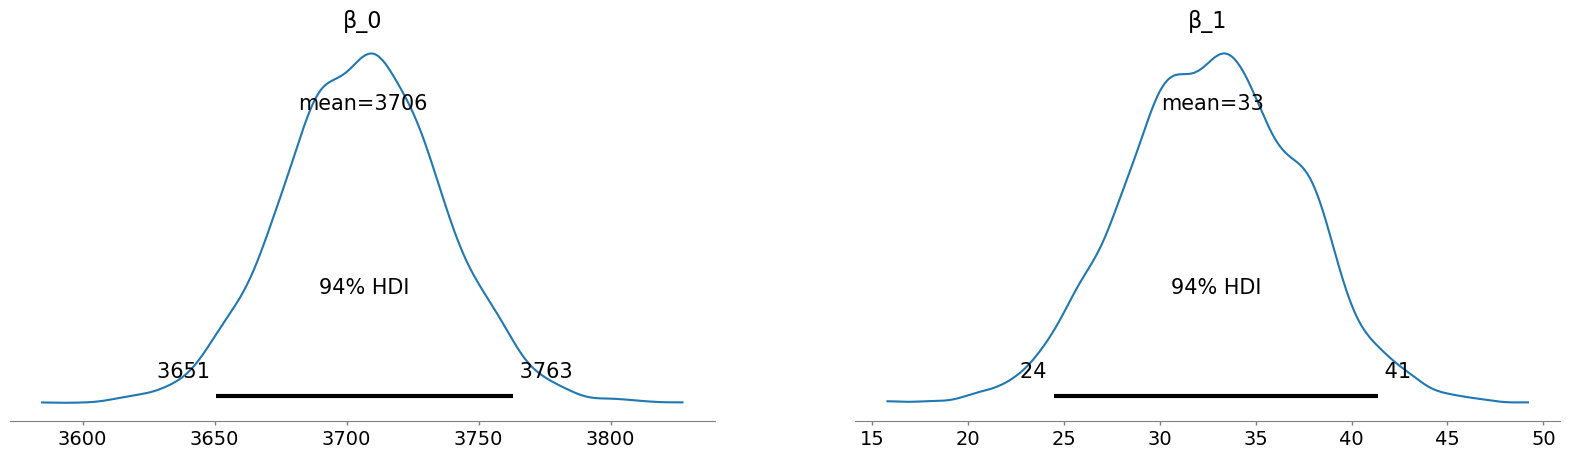

In [25]:
axes = az.plot_posterior(idata_adelie_flipper_regression_c, var_names = ["β_0", "β_1"], figsize=(20, 5));

Когда мы снова построим график наших коэффициентов, он будет таким же, как в нашей модели предидущей PyMC, но распределение
изменилось. 

Поскольку мы сдвинули наши входные данные на их средние значения, распределение
будет совпадает с нашим прогнозом для группового среднего значения с нецентрированным набором данных. 

Сдвинув данные, мы  можем непосредственно интерпретировать их как распределение средней массы пингвинов Adelie по средней длине плавников. 

Идея преобразования объясняющих переменных также может быть реализована при произвольных значениях по выбору. Например, мы могли бы вычесть минимальную длину плавников и подогнать ее под нашу модель. В данном преобразовании это изменило бы интерпретацию
распределения средних значений для наименьшей наблюдаемой длины плавника. Для более подробного обсуждения преобразований в линейной регрессии рекомендуется использовать прикладной регрессионный анализ и обобщенные линейные модели в эконометрике :).

In [27]:
with open('idata_adelie_flipper_regression.pkl', 'wb') as f:
     pickle.dump(idata_adelie_flipper_regression, f)